In [4]:
import numpy as np
import scipy.io as sio
import matplotlib.pyplot as plt
import math
from sklearn.utils.extmath import randomized_svd as fast_svd
from sklearn.decomposition import PCA
from hyperspy import signals

C:\Users\Chenyu\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


## This script tests matrix PCA performance on simulated data with different noise level

In [7]:
path ='D:/2020/TensorSVD/ManuscriptRelated/SimulationData/'
raw_data = sio.loadmat(path + 'DenoiseInput_fullsize/SiDislocation/Simulation_noisy_SiDisl_slc5_1000FPS.mat')
raw_data = raw_data['datacube']

truth_data = np.load(path + 'DenoiseInput_fullsize/SiDislocation/Simulation_truth_SiDisl_slc5_1000FPS.npy')

denoised_data = sio.loadmat(path + 'DenoiseOutput_fullsize/SiDislocation/Simulation_tensor_SiDisl_slc5_1000FPS.mat')
denoised_data = denoised_data['est_HOOI']

In [8]:
print(raw_data.shape)
print(truth_data.shape)
print(denoised_data.shape)

(114, 114, 16384)
(114, 114, 16384)
(114, 114, 16384)


In [35]:
raw_data.shape
raw_data_2D = np.reshape(raw_data,(raw_data.shape[0]*raw_data.shape[1],raw_data.shape[2]))
im = signals.Signal2D(raw_data_2D.astype('float'))
im = im.transpose(signal_axes = 1)
im

<Signal1D, title: , dimensions: (12996|16384)>

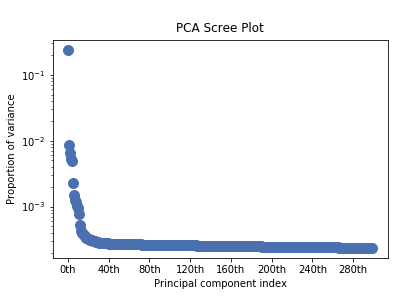

In [36]:
im.decomposition()
im.plot_explained_variance_ratio(n=300,linewidth=1)

In [37]:
im_denoise = im.get_decomposition_model(25)
PCA_data = np.asarray(im_denoise)
PCA_data = PCA_data.reshape(114,114,16384)
PCA_data.shape
np.save(path + 'DenoiseOutput_fullsize/SiDislocation/Simulation_PCA_SiDisl_slc5_1000FPS_25comp.npy',PCA_data)

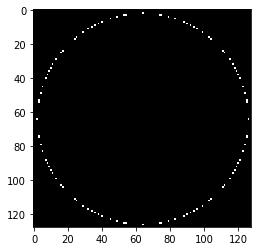

In [38]:
# A circular mask with less points can be generated by using a smaller gap between two radii
circular_mask = create_circular_mask(128, 128, center=(64,64), radius=62) & \
~create_circular_mask(128, 128, center=(64,64), radius=61.7)
plt.imshow(circular_mask)
ADF_noisy = np.zeros((raw_data.shape[0],raw_data.shape[1]))
ADF_denoised = np.zeros((raw_data.shape[0],raw_data.shape[1]))
ADF_truth = np.zeros((raw_data.shape[0],raw_data.shape[1]))
ADF_PCA = np.zeros((raw_data.shape[0],raw_data.shape[1]))

for i in range(128):
    for j in range(128):
        if circular_mask[i,j] == 1:
            ADF_noisy = ADF_noisy + raw_data[:,:,i*128+j]
            ADF_denoised = ADF_denoised + denoised_data[:,:,i*128+j]
            ADF_PCA = ADF_PCA + PCA_data[:,:,i*128+j]
            ADF_truth = ADF_truth + truth_data[:,:,i*128+j]

(-0.5, 113.5, 113.5, -0.5)

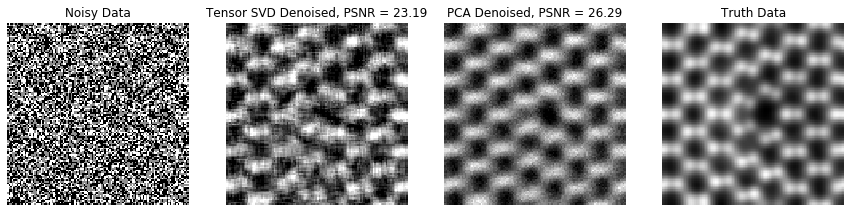

In [39]:
# Compare real space structure from ADF reconstrcutred from a ring with width = 1
plt.figure(figsize=(15,4))
clim_low = np.amin(ADF_truth)
clim_high = np.amax(ADF_truth)

plt.subplot(142)
plt.imshow(ADF_denoised,clim=[clim_low,clim_high],cmap='gray')
# plt.colorbar()
plt.axis('off')
PSNR = averagePSNR(denoised_data, truth_data, 0)
plt.title('Tensor SVD Denoised, PSNR = '+"{:.2f}".format(PSNR))

plt.subplot(143)
plt.imshow(ADF_PCA,clim=[clim_low,clim_high],cmap='gray')
# plt.colorbar()
plt.axis('off')
PSNR = averagePSNR(PCA_data, truth_data, 0)
plt.title('PCA Denoised, PSNR = '+"{:.2f}".format(PSNR))

plt.subplot(141)
plt.imshow(ADF_noisy,clim=[clim_low,clim_high],cmap='gray')
plt.title('Noisy Data')
plt.axis('off')
# plt.colorbar()

plt.subplot(144)
plt.imshow(ADF_truth,clim=[clim_low,clim_high],cmap='gray')
plt.title('Truth Data')
# plt.scatter(64,64)
plt.axis('off')
# plt.colorbar()

(-0.5, 127.5, 127.5, -0.5)

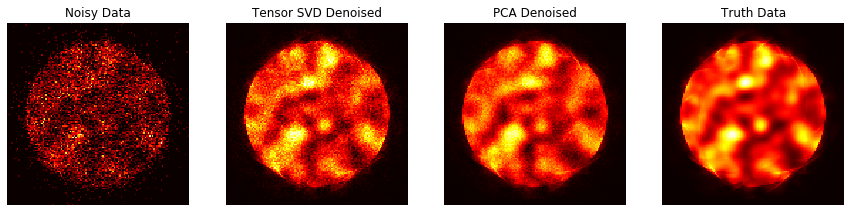

In [32]:
# Compare CBED from single rx,ry
plt.figure(figsize=(15,4))
rx = 50
ry = 60
clim_low = np.amin(truth_data[rx,ry,:])
clim_high = np.amax(truth_data[rx,ry,:])

plt.subplot(142)
plt.imshow(denoised_data[rx,ry,:].reshape(128,128),clim=[clim_low,clim_high],cmap='hot')
plt.axis('off')
plt.title('Tensor SVD Denoised')

plt.subplot(143)
plt.imshow(PCA_data[rx,ry,:].reshape(128,128),clim=[clim_low,clim_high],cmap='hot')
plt.axis('off')
plt.title('PCA Denoised')

plt.subplot(141)
plt.imshow(raw_data[rx,ry,:].reshape(128,128),cmap='hot')
plt.title('Noisy Data')
plt.axis('off')

plt.subplot(144)
plt.imshow(truth_data[rx,ry,:].reshape(128,128),clim=[clim_low,clim_high],cmap='hot')
plt.title('Truth Data')
plt.axis('off')


In [1]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None: # use the middle of the image
        center = [int(w/2), int(h/2)]
    if radius is None: # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w-center[0], h-center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0])**2 + (Y-center[1])**2)

    mask = dist_from_center <= radius
    return mask

In [2]:
# transpose_option = 1 for tensor denoised data, where first dimension is for rec space and need to be transposed to match simulation
# transpose_option = 0 for noisy data, third dimension is for rec space and no need to transpose
def averagePSNR(denoised_data,truth_data,transpose_option):
    side = np.sqrt(truth_data.shape[2])
    side = int(side)
    psnr_map = np.zeros((truth_data.shape[0],truth_data.shape[1]))
    for irow in range(truth_data.shape[0]):
        for icol in range(truth_data.shape[1]):
            truth = truth_data[irow,icol,:].reshape(side,side)
            if transpose_option == 1:
                denoise = np.transpose(denoised_data[:,irow,icol].reshape(side,side))
            else:
                denoise = denoised_data[irow,icol,:].reshape(side,side)
            psnr_map[irow,icol] = psnr(truth,denoise)
    return np.mean(psnr_map)

In [3]:
def psnr(truth, denoise):
    mse = np.mean( (truth - denoise) ** 2 )
    PIXEL_MAX = np.amax(truth)
    return 20 * math.log10(PIXEL_MAX / math.sqrt(mse))